<a href="https://colab.research.google.com/github/jasonphillip/Ames_Housing_ML_Project/blob/main/JASONFeature1AND2_FPGA_VectorBlox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =============================================================================
# CELL 1: Initial Setup and Imports
# =============================================================================

# Install the tensorflow-model-optimization library
!pip install -q tensorflow-model-optimization

# Mount Google Drive and import other dependencies
from google.colab import drive
import os, tempfile, pickle, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# Mount Google Drive
drive.mount('/content/drive')
print("✅ Setup complete!")

ERROR: Operation cancelled by user


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:

# =============================================================================
# CELL 2: Enhanced RML2016 Dataset Loader with FPGA Considerations
# =============================================================================

class RML2016DataLoader:
    """Enhanced RML2016.10a dataset loader optimized for FPGA deployment"""

    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.modulations = None
        self.snrs = None
        self.label_encoder = LabelEncoder()

    def load_data(self):
        """Load the RML2016.10a dataset"""
        print("Loading RML2016.10a dataset...")
        with open(self.data_path, 'rb') as f:
            self.data = pickle.load(f, encoding='latin1')

        # Extract unique modulations and SNRs
        modulations = set()
        snrs = set()
        for key in self.data.keys():
            mod, snr = key
            modulations.add(mod)
            snrs.add(snr)

        self.modulations = sorted(list(modulations))
        self.snrs = sorted(list(snrs))

        print(f"Loaded {len(self.modulations)} modulation types")
        print(f"SNR range: {min(self.snrs)} to {max(self.snrs)} dB")
        print(f"Modulations: {self.modulations}")

    def prepare_data(self, min_snr=-20, max_snr=18, test_size=0.2,
                     normalize=True, fpga_friendly=True):
        """
        Prepare data for training with FPGA considerations

        Args:
            min_snr: Minimum SNR to include
            max_snr: Maximum SNR to include
            test_size: Fraction for testing
            normalize: Whether to normalize data
            fpga_friendly: Apply FPGA-friendly preprocessing
        """
        if self.data is None:
            self.load_data()

        X = []
        y = []

        print(f"Preparing data for SNR range: {min_snr} to {max_snr} dB")

        for (mod, snr), samples in self.data.items():
            if min_snr <= snr <= max_snr:
                for sample in samples:
                    # Handle complex data
                    if sample.dtype == np.complex64 or sample.dtype == np.complex128:
                        # Convert complex to real representation [I, Q, I, Q, ...]
                        sample_real = np.column_stack([sample.real, sample.imag]).flatten()
                        X.append(sample_real)
                    else:
                        # Already real data
                        X.append(sample.flatten())
                    y.append(mod)

        X = np.array(X, dtype=np.float32)  # FPGA prefers float32
        y = np.array(y)

        # FPGA-friendly preprocessing
        if fpga_friendly:
            # Clip extreme values (helps with quantization)
            X = np.clip(X, -3.0, 3.0)

            # Scale to reasonable range for INT8 quantization
            if normalize:
                X = X / np.std(X)  # Normalize by global std
                X = np.clip(X, -2.0, 2.0)  # Clip again after normalization

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        print(f"Data shape: {X.shape}")
        print(f"Data range: [{X.min():.3f}, {X.max():.3f}]")
        print(f"Number of classes: {len(self.modulations)}")

        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )

        return X_train, X_test, y_train, y_test

    def get_data_by_snr(self, target_snr):
        """Get data for specific SNR level"""
        if self.data is None:
            self.load_data()

        X_snr = []
        y_snr = []

        for (mod, snr), samples in self.data.items():
            if snr == target_snr:
                for sample in samples:
                    if sample.dtype == np.complex64 or sample.dtype == np.complex128:
                        sample_real = np.column_stack([sample.real, sample.imag]).flatten()
                        X_snr.append(sample_real)
                    else:
                        X_snr.append(sample.flatten())
                    y_snr.append(self.label_encoder.transform([mod])[0])

        return np.array(X_snr, dtype=np.float32), np.array(y_snr)

    def get_class_names(self):
        """Get the class names"""
        return self.label_encoder.classes_

In [ ]:

# =============================================================================
# CELL 3: FPGA-Optimized Model Architectures
# =============================================================================

def create_fpga_minimal_model(input_shape=(256,), num_classes=11):
    """Ultra-lightweight model for FPGA proof-of-concept (~5K parameters)"""
    inputs = keras.Input(shape=input_shape)

    # Reshape to I/Q pairs
    x = layers.Reshape((128, 2))(inputs)

    # Minimal conv layers with powers-of-2 filters
    x = layers.Conv1D(16, 5, strides=4, activation='relu', padding='same')(x)  # 32 samples
    x = layers.BatchNormalization()(x)

    # Global pooling instead of flatten (more efficient)
    x = layers.GlobalAveragePooling1D()(x)

    # Small dense layer
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='FPGA_Minimal')
    return model

def create_fpga_optimized_model(input_shape=(256,), num_classes=11):
    """Balanced model for FPGA deployment (~25K parameters)"""
    inputs = keras.Input(shape=input_shape)

    # Reshape to I/Q pairs
    x = layers.Reshape((128, 2))(inputs)

    # Optimized conv layers with powers-of-2
    x = layers.Conv1D(32, 5, strides=2, padding='same', activation='relu')(x)  # 64 samples
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 5, strides=2, padding='same', activation='relu')(x)  # 32 samples
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 3, strides=2, padding='same', activation='relu')(x)  # 16 samples
    x = layers.BatchNormalization()(x)

    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='FPGA_Optimized')
    return model

def create_quantization_aware_model(base_model):
    """Apply quantization-aware training to model with robust fallbacks"""

    # Check if model is compatible with quantization
    if not hasattr(base_model, 'layers'):
        print("⚠️  Model not compatible with quantization")
        return base_model

    try:
        # Method 1: Try the simplest default quantization
        quantized_model = tfmot.quantization.keras.quantize_model(base_model)
        print("✅ Using default quantization configuration")
        return quantized_model

    except Exception as e1:
        print(f"⚠️  Default quantization failed: {e1}")

        try:
            # Method 2: Try with quantize_scope (for newer TF versions)
            with tfmot.quantization.keras.quantize_scope():
                quantized_model = tfmot.quantization.keras.quantize_model(base_model)
            print("✅ Using quantize_scope configuration")
            return quantized_model

        except Exception as e2:
            print(f"⚠️  Quantize scope failed: {e2}")

            try:
                # Method 3: Try to quantize specific layers manually
                def apply_quantization_to_dense(layer):
                    if isinstance(layer, tf.keras.layers.Dense):
                        return tfmot.quantization.keras.quantize_annotate_layer(layer)
                    return layer

                def apply_quantization_to_conv(layer):
                    if isinstance(layer, tf.keras.layers.Conv1D):
                        return tfmot.quantization.keras.quantize_annotate_layer(layer)
                    return layer

                # Clone model and apply quantization annotations
                annotated_model = tf.keras.models.clone_model(
                    base_model,
                    clone_function=apply_quantization_to_dense,
                )

                annotated_model = tf.keras.models.clone_model(
                    annotated_model,
                    clone_function=apply_quantization_to_conv,
                )

                # Apply quantization
                quantized_model = tfmot.quantization.keras.quantize_apply(annotated_model)
                print("✅ Using manual layer quantization")
                return quantized_model

            except Exception as e3:
                print(f"⚠️  Manual quantization failed: {e3}")
                print("📋 Falling back to FP32 model - quantization will be applied during TFLite conversion")
                return base_model


In [ ]:

# =============================================================================
# CELL 4: FPGA Model Analysis Tools
# =============================================================================

class FPGAModelAnalyzer:
    """Comprehensive FPGA deployment analysis"""

    def __init__(self, model):
        self.model = model

    def analyze_fpga_metrics(self):
        """Critical FPGA deployment metrics"""

        # Parameter analysis
        total_params = self.model.count_params()
        trainable_params = sum([np.prod(v.shape) for v in self.model.trainable_variables])

        # Memory requirements (INT8)
        weight_memory_kb = (total_params * 1) / 1024  # 1 byte per INT8 weight

        # Estimate activation memory (conservative estimate)
        max_activation_size = 0
        for layer in self.model.layers:
            if hasattr(layer, 'output_shape') and layer.output_shape:
                if layer.output_shape[1:]:  # Skip None dimensions
                    activation_elements = np.prod([d for d in layer.output_shape[1:] if d is not None])
                    max_activation_size = max(max_activation_size, activation_elements)

        activation_memory_kb = (max_activation_size * 1) / 1024  # INT8 activations
        total_memory_kb = weight_memory_kb + activation_memory_kb

        print(f"=== FPGA Memory Analysis ===")
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")
        print(f"Weight Memory (INT8): {weight_memory_kb:.1f} KB")
        print(f"Max Activation Memory: {activation_memory_kb:.1f} KB")
        print(f"Total Memory Required: {total_memory_kb:.1f} KB")

        # PolarFire SoC memory constraints
        if total_memory_kb > 1024:
            print(f"⚠️  WARNING: Exceeds typical on-chip memory (1MB)")
            print(f"📊 Consider external memory or model compression")
        else:
            print(f"✅ Fits in on-chip memory")
            utilization = (total_memory_kb / 1024) * 100
            print(f"📊 Memory utilization: {utilization:.1f}%")

        return {
            'total_params': total_params,
            'weight_memory_kb': weight_memory_kb,
            'activation_memory_kb': activation_memory_kb,
            'total_memory_kb': total_memory_kb,
            'fits_on_chip': total_memory_kb <= 1024,
            'memory_utilization_percent': (total_memory_kb / 1024) * 100
        }

    def estimate_inference_performance(self, clock_freq_mhz=100):
        """Estimate FPGA inference performance"""

        total_macs = 0

        for layer in self.model.layers:
            if isinstance(layer, layers.Conv1D):
                # Conv1D MAC calculation
                if hasattr(layer, 'kernel_size'):
                    kernel_size = layer.kernel_size[0]
                    filters = layer.filters
                    # Estimate based on typical dimensions
                    if hasattr(layer, 'input_shape') and layer.input_shape[1:]:
                        input_length = layer.input_shape[1] if layer.input_shape[1] else 128
                        input_channels = layer.input_shape[2] if layer.input_shape[2] else 2
                    else:
                        input_length = 128
                        input_channels = 2

                    strides = layer.strides[0] if hasattr(layer, 'strides') else 1
                    output_length = input_length // strides

                    layer_macs = output_length * filters * kernel_size * input_channels
                    total_macs += layer_macs

            elif isinstance(layer, layers.Dense):
                # Dense layer MACs
                if hasattr(layer, 'units'):
                    output_size = layer.units
                    # Estimate input size
                    if hasattr(layer, 'input_shape') and layer.input_shape[1:]:
                        input_size = layer.input_shape[1] if layer.input_shape[1] else 64
                    else:
                        input_size = 64

                    layer_macs = input_size * output_size
                    total_macs += layer_macs

        # VectorBlox performance estimation
        vectorblox_parallel_macs = 16  # Conservative estimate for small instance
        estimated_cycles = total_macs / vectorblox_parallel_macs

        # Timing calculations
        cycles_per_second = clock_freq_mhz * 1e6
        inference_time_us = (estimated_cycles / cycles_per_second) * 1e6
        max_inferences_per_second = cycles_per_second / estimated_cycles

        print(f"=== FPGA Performance Analysis ===")
        print(f"Total MAC Operations: {total_macs:,}")
        print(f"Estimated Cycles: {estimated_cycles:,.0f}")
        print(f"Inference Time @ {clock_freq_mhz}MHz: {inference_time_us:.1f} μs")
        print(f"Max Inference Rate: {max_inferences_per_second:,.0f} Hz")

        return {
            'total_macs': total_macs,
            'estimated_cycles': estimated_cycles,
            'inference_time_us': inference_time_us,
            'max_inference_rate_hz': max_inferences_per_second
        }

    def check_real_time_capability(self, sample_rate=2e6, samples_per_inference=128):
        """Check if model can handle real-time processing"""

        # Required inference rate
        required_rate_hz = sample_rate / samples_per_inference

        # Get performance metrics
        perf = self.estimate_inference_performance()
        achievable_rate_hz = perf['max_inference_rate_hz']

        print(f"=== Real-Time Analysis ===")
        print(f"Sample Rate: {sample_rate/1e6:.1f} MSps")
        print(f"Samples per Inference: {samples_per_inference}")
        print(f"Required Inference Rate: {required_rate_hz:,.0f} Hz")
        print(f"Achievable Inference Rate: {achievable_rate_hz:,.0f} Hz")

        if achievable_rate_hz >= required_rate_hz:
            utilization = (required_rate_hz / achievable_rate_hz) * 100
            print(f"✅ Real-time capable")
            print(f"📊 Compute utilization: {utilization:.1f}%")
            margin = achievable_rate_hz / required_rate_hz
            print(f"📊 Performance margin: {margin:.1f}x")
        else:
            shortfall = required_rate_hz / achievable_rate_hz
            print(f"❌ Cannot handle real-time")
            print(f"📊 Need {shortfall:.1f}x speedup")

        return {
            'required_rate_hz': required_rate_hz,
            'achievable_rate_hz': achievable_rate_hz,
            'real_time_capable': achievable_rate_hz >= required_rate_hz,
            'utilization_percent': (required_rate_hz / achievable_rate_hz) * 100 if achievable_rate_hz > 0 else 100
        }


In [ ]:

# =============================================================================
# CELL 5: Enhanced Model Training with Cross-Validation
# =============================================================================

class RFModelTrainer:
    """Enhanced training pipeline with FPGA considerations"""

    def __init__(self, model_type='fpga_optimized'):
        self.model_type = model_type
        self.model = None
        self.history = None

    def create_model(self, input_shape=(256,), num_classes=11, quantization_aware=True):
        """Create model based on type"""

        if self.model_type == 'fpga_minimal':
            base_model = create_fpga_minimal_model(input_shape, num_classes)
        elif self.model_type == 'fpga_optimized':
            base_model = create_fpga_optimized_model(input_shape, num_classes)
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")

        # Apply quantization-aware training if requested and available
        if quantization_aware:
            try:
                self.model = create_quantization_aware_model(base_model)
                print(f"✅ Created {self.model_type} model with quantization-aware training")
            except Exception as e:
                print(f"⚠️  Quantization-aware training failed: {e}")
                print(f"📋 Using FP32 model (will quantize during deployment)")
                self.model = base_model
        else:
            self.model = base_model
            print(f"✅ Created {self.model_type} model (FP32)")

        return self.model

    def train_model(self, X_train, y_train, X_test, y_test,
                    epochs=50, batch_size=128, validation_split=0.2):
        """Train model with early stopping and learning rate scheduling"""

        if self.model is None:
            raise ValueError("Model not created. Call create_model() first.")

        # Convert labels to categorical
        y_train_cat = keras.utils.to_categorical(y_train, 11)
        y_test_cat = keras.utils.to_categorical(y_test, 11)

        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks for robust training
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        print(f"\n🚀 Training {self.model_type} model...")
        print(f"📊 Parameters: {self.model.count_params():,}")

        # Train model
        self.history = self.model.fit(
            X_train, y_train_cat,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test_cat),
            callbacks=callbacks,
            verbose=1
        )

        # Final evaluation
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test_cat, verbose=0)
        print(f"\n✅ Training complete!")
        print(f"📊 Final Test Accuracy: {test_accuracy:.4f}")

        return self.history, test_accuracy

    def cross_validate(self, X, y, n_splits=5, epochs=30):
        """Perform cross-validation for more robust evaluation"""

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_results = {
            'accuracies': [],
            'losses': [],
            'fold_histories': []
        }

        print(f"\n🔄 Starting {n_splits}-fold cross-validation...")

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"\n📁 Fold {fold + 1}/{n_splits}")

            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Create fresh model for each fold
            model = self.create_model(quantization_aware=True)
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Convert to categorical
            y_train_cat = keras.utils.to_categorical(y_train_fold, 11)
            y_val_cat = keras.utils.to_categorical(y_val_fold, 11)

            # Train
            history = model.fit(
                X_train_fold, y_train_cat,
                validation_data=(X_val_fold, y_val_cat),
                epochs=epochs,
                batch_size=128,
                verbose=0,
                callbacks=[
                    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
                ]
            )

            # Evaluate
            val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_cat, verbose=0)
            cv_results['accuracies'].append(val_accuracy)
            cv_results['losses'].append(val_loss)
            cv_results['fold_histories'].append(history.history)

            print(f"📊 Fold {fold + 1} Accuracy: {val_accuracy:.4f}")

        # Summary statistics
        cv_results['mean_accuracy'] = np.mean(cv_results['accuracies'])
        cv_results['std_accuracy'] = np.std(cv_results['accuracies'])
        cv_results['mean_loss'] = np.mean(cv_results['losses'])

        print(f"\n✅ Cross-validation complete!")
        print(f"📊 Mean Accuracy: {cv_results['mean_accuracy']:.4f} ± {cv_results['std_accuracy']:.4f}")
        print(f"📊 Accuracy Range: [{min(cv_results['accuracies']):.4f}, {max(cv_results['accuracies']):.4f}]")

        return cv_results


In [ ]:


# =============================================================================
# CELL 6: SNR-Aware Evaluation Framework
# =============================================================================

class SNRAwareEvaluator:
    """Evaluate model performance across different SNR levels"""

    def __init__(self, model, loader, class_names):
        self.model = model
        self.loader = loader
        self.class_names = class_names

    def evaluate_by_snr(self, snr_range=None):
        """Evaluate performance for each SNR level"""

        if snr_range is None:
            snr_range = self.loader.snrs

        snr_results = {}

        print("🔍 Evaluating performance by SNR level...")

        for snr in snr_range:
            X_snr, y_snr = self.loader.get_data_by_snr(snr)

            if len(X_snr) > 0:
                # Predict
                predictions = self.model.predict(X_snr, verbose=0)
                y_pred = np.argmax(predictions, axis=1)

                # Calculate metrics
                accuracy = accuracy_score(y_snr, y_pred)
                precision = precision_score(y_snr, y_pred, average='macro', zero_division=0)
                recall = recall_score(y_snr, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y_snr, y_pred, average='macro', zero_division=0)

                snr_results[snr] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'samples': len(X_snr),
                    'confusion_matrix': confusion_matrix(y_snr, y_pred)
                }

                print(f"📊 SNR {snr:2d} dB: Acc={accuracy:.3f}, Samples={len(X_snr):,}")

        return snr_results

    def plot_snr_performance(self, snr_results):
        """Plot performance vs SNR"""

        snrs = sorted(snr_results.keys())
        accuracies = [snr_results[snr]['accuracy'] for snr in snrs]
        precisions = [snr_results[snr]['precision'] for snr in snrs]
        recalls = [snr_results[snr]['recall'] for snr in snrs]
        f1_scores = [snr_results[snr]['f1_score'] for snr in snrs]

        plt.figure(figsize=(15, 10))

        # Main performance plot
        plt.subplot(2, 2, 1)
        plt.plot(snrs, accuracies, 'o-', linewidth=2, markersize=8, label='Accuracy')
        plt.plot(snrs, precisions, 's-', linewidth=2, markersize=6, label='Precision')
        plt.plot(snrs, recalls, '^-', linewidth=2, markersize=6, label='Recall')
        plt.plot(snrs, f1_scores, 'd-', linewidth=2, markersize=6, label='F1-Score')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Score')
        plt.title('Model Performance vs SNR')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.ylim(0, 1)

        # Sample distribution
        plt.subplot(2, 2, 2)
        sample_counts = [snr_results[snr]['samples'] for snr in snrs]
        plt.bar(snrs, sample_counts, alpha=0.7)
        plt.xlabel('SNR (dB)')
        plt.ylabel('Number of Samples')
        plt.title('Dataset Distribution by SNR')
        plt.grid(True, alpha=0.3)

        # Accuracy heatmap by modulation and SNR
        plt.subplot(2, 1, 2)
        self._plot_snr_modulation_heatmap(snr_results, snrs)

        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\n📊 SNR Performance Summary:")
        print(f"Best performance: {max(accuracies):.3f} at {snrs[np.argmax(accuracies)]} dB")
        print(f"Worst performance: {min(accuracies):.3f} at {snrs[np.argmin(accuracies)]} dB")

        # Find SNR threshold for 80% accuracy
        threshold_snr = None
        for snr, acc in zip(snrs, accuracies):
            if acc >= 0.8:
                threshold_snr = snr
                break

        if threshold_snr is not None:
            print(f"SNR for 80% accuracy: {threshold_snr} dB")
        else:
            print("Never reaches 80% accuracy in tested range")

    def _plot_snr_modulation_heatmap(self, snr_results, snrs):
        """Create heatmap of accuracy by SNR and modulation type"""

        # Calculate per-class accuracy for each SNR
        accuracy_matrix = []

        for snr in snrs:
            if snr in snr_results:
                cm = snr_results[snr]['confusion_matrix']
                # Calculate per-class accuracy from confusion matrix
                class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
                # Handle division by zero
                class_accuracies = np.nan_to_num(class_accuracies)
                accuracy_matrix.append(class_accuracies)
            else:
                accuracy_matrix.append(np.zeros(len(self.class_names)))

        accuracy_matrix = np.array(accuracy_matrix).T  # Transpose for plotting

        # Create heatmap
        sns.heatmap(accuracy_matrix,
                   xticklabels=snrs,
                   yticklabels=self.class_names,
                   cmap='RdYlGn',
                   vmin=0, vmax=1,
                   annot=False,
                   cbar_kws={'label': 'Accuracy'})

        plt.xlabel('SNR (dB)')
        plt.ylabel('Modulation Type')
        plt.title('Per-Class Accuracy vs SNR')


In [ ]:


# =============================================================================
# CELL 7: VectorBlox Deployment Tools
# =============================================================================

class VectorBloxDeployment:
    """Tools for preparing models for VectorBlox deployment"""

    def __init__(self, model):
        self.model = model

    def prepare_for_deployment(self, X_representative, output_dir='vectorblox_models'):
        """Complete deployment preparation pipeline"""

        os.makedirs(output_dir, exist_ok=True)

        results = {}

        # 1. Save original model
        fp32_path = os.path.join(output_dir, 'model_fp32.h5')
        self.model.save(fp32_path, include_optimizer=False)
        fp32_size = os.path.getsize(fp32_path) / 1024  # KB

        print(f"💾 Saved FP32 model: {fp32_size:.1f} KB")

        # 2. Create TFLite INT8 model
        int8_model, int8_path, int8_size = self._create_int8_tflite(
            X_representative, output_dir
        )

        # 3. Validate quantized model
        accuracy_comparison = self._validate_quantized_model(
            int8_model, X_representative[:100]  # Use subset for validation
        )

        # 4. Generate deployment report
        deployment_report = self._generate_deployment_report(
            fp32_size, int8_size, accuracy_comparison
        )

        results = {
            'fp32_path': fp32_path,
            'int8_path': int8_path,
            'fp32_size_kb': fp32_size,
            'int8_size_kb': int8_size,
            'size_reduction_percent': ((fp32_size - int8_size) / fp32_size) * 100,
            'quantization_report': accuracy_comparison,
            'deployment_report': deployment_report
        }

        return results

    def _create_int8_tflite(self, X_representative, output_dir):
        """Create INT8 quantized TFLite model with improved error handling"""

        # Representative dataset for quantization
        def representative_dataset():
            for i in range(min(100, len(X_representative))):
                # Ensure data is properly shaped and typed
                sample = X_representative[i:i+1].astype(np.float32)
                yield [sample]

        print("🔄 Converting to TFLite with INT8 quantization...")

        # Try full integer quantization first (best for VectorBlox)
        try:
            converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.representative_dataset = representative_dataset

            # Force full integer quantization
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.uint8
            converter.inference_output_type = tf.uint8

            tflite_model = converter.convert()
            quantization_type = "Full INT8"
            print("✅ Full INT8 quantization successful")

        except Exception as e1:
            print(f"⚠️  Full INT8 quantization failed: {e1}")

            try:
                # Fallback to dynamic range quantization
                converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
                converter.optimizations = [tf.lite.Optimize.DEFAULT]
                converter.representative_dataset = representative_dataset

                tflite_model = converter.convert()
                quantization_type = "Dynamic Range"
                print("✅ Dynamic range quantization successful")

            except Exception as e2:
                print(f"⚠️  Dynamic range quantization failed: {e2}")

                try:
                    # Last resort: basic optimization only
                    converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
                    converter.optimizations = [tf.lite.Optimize.DEFAULT]

                    tflite_model = converter.convert()
                    quantization_type = "Basic Optimization"
                    print("⚠️  Using basic optimization only")

                except Exception as e3:
                    # Absolute fallback: no optimization
                    print(f"❌ All quantization methods failed: {e3}")
                    converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
                    tflite_model = converter.convert()
                    quantization_type = "No Quantization (FP32)"
                    print("⚠️  Using FP32 model without quantization")

        # Save model
        int8_path = os.path.join(output_dir, 'model_int8.tflite')
        with open(int8_path, 'wb') as f:
            f.write(tflite_model)

        int8_size = len(tflite_model) / 1024  # KB

        print(f"💾 Saved TFLite model: {int8_size:.1f} KB ({quantization_type})")

        # Calculate size reduction if we have a reference
        try:
            fp32_path = os.path.join(output_dir, 'model_fp32.h5')
            if os.path.exists(fp32_path):
                fp32_size_kb = os.path.getsize(fp32_path) / 1024
                reduction = ((fp32_size_kb - int8_size) / fp32_size_kb) * 100
                print(f"📊 Size reduction: {reduction:.1f}%")
        except:
            pass

        return tflite_model, int8_path, int8_size

    def _validate_quantized_model(self, tflite_model, X_test):
        """Validate quantized model accuracy"""

        # Load TFLite interpreter
        interpreter = tf.lite.Interpreter(model_content=tflite_model)
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Get quantization parameters
        input_scale, input_zero_point = input_details[0]['quantization']
        output_scale, output_zero_point = output_details[0]['quantization']

        print(f"🔍 Quantization parameters:")
        print(f"  Input: scale={input_scale:.6f}, zero_point={input_zero_point}")
        print(f"  Output: scale={output_scale:.6f}, zero_point={output_zero_point}")

        # Test inference on sample data
        test_sample = X_test[0:1].astype(np.float32)

        # Original model prediction
        original_pred = self.model.predict(test_sample, verbose=0)

        # Quantized model prediction
        # Quantize input
        test_sample_quantized = test_sample / input_scale + input_zero_point
        test_sample_quantized = np.clip(test_sample_quantized, 0, 255).astype(np.uint8)

        interpreter.set_tensor(input_details[0]['index'], test_sample_quantized)
        interpreter.invoke()

        # Get and dequantize output
        output_quantized = interpreter.get_tensor(output_details[0]['index'])
        quantized_pred = (output_quantized.astype(np.float32) - output_zero_point) * output_scale

        # Compare predictions
        original_class = np.argmax(original_pred)
        quantized_class = np.argmax(quantized_pred)

        print(f"✅ Quantization validation:")
        print(f"  Original prediction: class {original_class}, confidence {np.max(original_pred):.3f}")
        print(f"  Quantized prediction: class {quantized_class}, confidence {np.max(quantized_pred):.3f}")
        print(f"  Classes match: {original_class == quantized_class}")

        return {
            'original_prediction': original_pred,
            'quantized_prediction': quantized_pred,
            'classes_match': original_class == quantized_class,
            'input_quantization': (input_scale, input_zero_point),
            'output_quantization': (output_scale, output_zero_point),
            'interpreter': interpreter
        }

    def _generate_deployment_report(self, fp32_size, int8_size, accuracy_comparison):
        """Generate comprehensive deployment report"""

        # FPGA analysis
        analyzer = FPGAModelAnalyzer(self.model)
        memory_analysis = analyzer.analyze_fpga_metrics()
        performance_analysis = analyzer.estimate_inference_performance()
        real_time_analysis = analyzer.check_real_time_capability()

        report = f"""
=== VectorBlox Deployment Report ===

📊 Model Compression:
  • FP32 model size: {fp32_size:.1f} KB
  • INT8 model size: {int8_size:.1f} KB
  • Compression ratio: {((fp32_size - int8_size) / fp32_size) * 100:.1f}%

🧠 FPGA Memory Requirements:
  • Total parameters: {memory_analysis['total_params']:,}
  • Weight memory: {memory_analysis['weight_memory_kb']:.1f} KB
  • Activation memory: {memory_analysis['activation_memory_kb']:.1f} KB
  • Total memory: {memory_analysis['total_memory_kb']:.1f} KB
  • Fits on-chip: {'✅ Yes' if memory_analysis['fits_on_chip'] else '❌ No'}

⚡ Performance Estimates:
  • Total MAC operations: {performance_analysis['total_macs']:,}
  • Inference time: {performance_analysis['inference_time_us']:.1f} μs
  • Max inference rate: {performance_analysis['max_inference_rate_hz']:,.0f} Hz

🔄 Real-Time Capability:
  • Real-time capable: {'✅ Yes' if real_time_analysis['real_time_capable'] else '❌ No'}
  • Compute utilization: {real_time_analysis['utilization_percent']:.1f}%

✅ Deployment Ready: {'Yes' if memory_analysis['fits_on_chip'] and real_time_analysis['real_time_capable'] else 'Needs optimization'}
        """

        print(report)
        return report

# # =============================================================================
# # CELL 7: VectorBlox Deployment Tools
# # =============================================================================

# class VectorBloxDeployment:
#     """Tools for preparing models for VectorBlox deployment"""

#     def __init__(self, model):
#         self.model = model

#     def prepare_for_deployment(self, X_representative, output_dir='vectorblox_models'):
#         """Complete deployment preparation pipeline"""

#         os.makedirs(output_dir, exist_ok=True)

#         results = {}

#         # 1. Save original model
#         fp32_path = os.path.join(output_dir, 'model_fp32.h5')
#         self.model.save(fp32_path, include_optimizer=False)
#         fp32_size = os.path.getsize(fp32_path) / 1024  # KB

#         print(f"💾 Saved FP32 model: {fp32_size:.1f} KB")

#         # 2. Create TFLite INT8 model
#         int8_model, int8_path, int8_size = self._create_int8_tflite(
#             X_representative, output_dir
#         )

#         # 3. Validate quantized model
#         accuracy_comparison = self._validate_quantized_model(
#             int8_model, X_representative[:100]  # Use subset for validation
#         )

#         # 4. Generate deployment report
#         deployment_report = self._generate_deployment_report(
#             fp32_size, int8_size, accuracy_comparison
#         )

#         results = {
#             'fp32_path': fp32_path,
#             'int8_path': int8_path,
#             'fp32_size_kb': fp32_size,
#             'int8_size_kb': int8_size,
#             'size_reduction_percent': ((fp32_size - int8_size) / fp32_size) * 100,
#             'quantization_report': accuracy_comparison,
#             'deployment_report': deployment_report
#         }

#         return results

#     def _create_int8_tflite(self, X_representative, output_dir):
#         """Create INT8 quantized TFLite model"""

#         # Representative dataset for quantization
#         def representative_dataset():
#             for i in range(min(100, len(X_representative))):
#                 yield [X_representative[i:i+1].astype(np.float32)]

#         # Convert to TFLite with full INT8 quantization
#         converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
#         converter.optimizations = [tf.lite.Optimize.DEFAULT]
#         converter.representative_dataset = representative_dataset

#         # Force INT8 quantization (required for VectorBlox)
#         converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#         converter.inference_input_type = tf.uint8
#         converter.inference_output_type = tf.uint8

#         try:
#             tflite_model = converter.convert()
#         except Exception as e:
#             print(f"❌ INT8 conversion failed: {e}")
#             # Fallback to dynamic range quantization
#             converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
#             converter.optimizations = [tf.lite.Optimize.DEFAULT]
#             tflite_model = converter.convert()
#             print("⚠️  Using dynamic range quantization instead")

#         # Save model
#         int8_path = os.path.join(output_dir, 'model_int8.tflite')
#         with open(int8_path, 'wb') as f:
#             f.write(tflite_model)

#         int8_size = len(tflite_model) / 1024  # KB

#         print(f"💾 Saved INT8 model: {int8_size:.1f} KB")
#         print(f"📊 Size reduction: {((1 - int8_size/os.path.getsize(os.path.join(output_dir, 'model_fp32.h5'))*1024)*100):.1f}%")

#         return tflite_model, int8_path, int8_size

#     def _validate_quantized_model(self, tflite_model, X_test):
#         """Validate quantized model accuracy"""

#         # Load TFLite interpreter
#         interpreter = tf.lite.Interpreter(model_content=tflite_model)
#         interpreter.allocate_tensors()

#         input_details = interpreter.get_input_details()
#         output_details = interpreter.get_output_details()

#         # Get quantization parameters
#         input_scale, input_zero_point = input_details[0]['quantization']
#         output_scale, output_zero_point = output_details[0]['quantization']

#         print(f"🔍 Quantization parameters:")
#         print(f"  Input: scale={input_scale:.6f}, zero_point={input_zero_point}")
#         print(f"  Output: scale={output_scale:.6f}, zero_point={output_zero_point}")

#         # Test inference on sample data
#         test_sample = X_test[0:1].astype(np.float32)

#         # Original model prediction
#         original_pred = self.model.predict(test_sample, verbose=0)

#         # Quantized model prediction
#         # Quantize input
#         test_sample_quantized = test_sample / input_scale + input_zero_point
#         test_sample_quantized = np.clip(test_sample_quantized, 0, 255).astype(np.uint8)

#         interpreter.set_tensor(input_details[0]['index'], test_sample_quantized)
#         interpreter.invoke()

#         # Get and dequantize output
#         output_quantized = interpreter.get_tensor(output_details[0]['index'])
#         quantized_pred = (output_quantized.astype(np.float32) - output_zero_point) * output_scale

#         # Compare predictions
#         original_class = np.argmax(original_pred)
#         quantized_class = np.argmax(quantized_pred)

#         print(f"✅ Quantization validation:")
#         print(f"  Original prediction: class {original_class}, confidence {np.max(original_pred):.3f}")
#         print(f"  Quantized prediction: class {quantized_class}, confidence {np.max(quantized_pred):.3f}")
#         print(f"  Classes match: {original_class == quantized_class}")

#         return {
#             'original_prediction': original_pred,
#             'quantized_prediction': quantized_pred,
#             'classes_match': original_class == quantized_class,
#             'input_quantization': (input_scale, input_zero_point),
#             'output_quantization': (output_scale, output_zero_point),
#             'interpreter': interpreter
#         }

#     def _generate_deployment_report(self, fp32_size, int8_size, accuracy_comparison):
#         """Generate comprehensive deployment report"""

#         # FPGA analysis
#         analyzer = FPGAModelAnalyzer(self.model)
#         memory_analysis = analyzer.analyze_fpga_metrics()
#         performance_analysis = analyzer.estimate_inference_performance()
#         real_time_analysis = analyzer.check_real_time_capability()

#         report = f"""
# === VectorBlox Deployment Report ===

# 📊 Model Compression:
#   • FP32 model size: {fp32_size:.1f} KB
#   • INT8 model size: {int8_size:.1f} KB
#   • Compression ratio: {((fp32_size - int8_size) / fp32_size) * 100:.1f}%

# 🧠 FPGA Memory Requirements:
#   • Total parameters: {memory_analysis['total_params']:,}
#   • Weight memory: {memory_analysis['weight_memory_kb']:.1f} KB
#   • Activation memory: {memory_analysis['activation_memory_kb']:.1f} KB
#   • Total memory: {memory_analysis['total_memory_kb']:.1f} KB
#   • Fits on-chip: {'✅ Yes' if memory_analysis['fits_on_chip'] else '❌ No'}

# ⚡ Performance Estimates:
#   • Total MAC operations: {performance_analysis['total_macs']:,}
#   • Inference time: {performance_analysis['inference_time_us']:.1f} μs
#   • Max inference rate: {performance_analysis['max_inference_rate_hz']:,.0f} Hz

# 🔄 Real-Time Capability:
#   • Real-time capable: {'✅ Yes' if real_time_analysis['real_time_capable'] else '❌ No'}
#   • Compute utilization: {real_time_analysis['utilization_percent']:.1f}%

# ✅ Deployment Ready: {'Yes' if memory_analysis['fits_on_chip'] and real_time_analysis['real_time_capable'] else 'Needs optimization'}
#         """

#         print(report)
#         return report

In [ ]:

# =============================================================================
# CELL 8: Compact FPGA Anomaly Detection
# =============================================================================

class CompactRFAnomalyDetector:
    """Lightweight anomaly detector optimized for FPGA deployment"""

    def __init__(self, input_dim=256, encoding_dim=16):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None
        self.scaler = StandardScaler()
        self.threshold = None

    def build_fpga_autoencoder(self):
        """Build compact autoencoder suitable for FPGA"""

        inputs = keras.Input(shape=(self.input_dim,))

        # Encoder - Very compact
        x = layers.Reshape((128, 2))(inputs)
        x = layers.Conv1D(16, 5, strides=4, activation='relu', padding='same')(x)  # 32 samples
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(8, 3, strides=2, activation='relu', padding='same')(x)   # 16 samples
        x = layers.BatchNormalization()(x)
        x = layers.Flatten()(x)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(x)

        # Decoder - Mirror structure
        x = layers.Dense(16 * 8, activation='relu')(encoded)
        x = layers.Reshape((16, 8))(x)
        x = layers.Conv1DTranspose(8, 3, strides=2, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1DTranspose(16, 5, strides=4, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(2, 3, activation='linear', padding='same')(x)
        decoded = layers.Flatten()(x)

        self.autoencoder = keras.Model(inputs, decoded)

        # Compile with MSE loss
        self.autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        print(f"🤖 Built compact autoencoder:")
        print(f"   Parameters: {self.autoencoder.count_params():,}")

        return self.autoencoder

    def prepare_normal_data(self, loader, min_snr=10, samples_per_mod=200):
        """Prepare clean normal signals for training"""

        X_normal = []

        for (mod, snr), samples in loader.data.items():
            if snr >= min_snr:
                # Take limited samples per modulation for efficiency
                selected_samples = samples[:samples_per_mod]
                for sample in selected_samples:
                    if sample.dtype == np.complex64 or sample.dtype == np.complex128:
                        sample_real = np.column_stack([sample.real, sample.imag]).flatten()
                        X_normal.append(sample_real)
                    else:
                        X_normal.append(sample.flatten())

        X_normal = np.array(X_normal, dtype=np.float32)

        # FPGA-friendly preprocessing
        X_normal = np.clip(X_normal, -3.0, 3.0)
        X_normal_scaled = self.scaler.fit_transform(X_normal)

        print(f"📊 Prepared {len(X_normal_scaled)} normal samples")
        print(f"   Data range: [{X_normal_scaled.min():.3f}, {X_normal_scaled.max():.3f}]")

        return X_normal_scaled

    def train(self, X_normal, epochs=30, batch_size=64):
        """Train autoencoder on normal data"""

        if self.autoencoder is None:
            self.build_fpga_autoencoder()

        print(f"🚀 Training compact autoencoder...")

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]

        history = self.autoencoder.fit(
            X_normal, X_normal,  # Autoencoder trains to reconstruct input
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def compute_threshold(self, X_normal, percentile=95):
        """Compute anomaly threshold from normal data"""

        reconstructions = self.autoencoder.predict(X_normal, verbose=0)
        reconstruction_errors = np.mean(np.square(X_normal - reconstructions), axis=1)

        self.threshold = np.percentile(reconstruction_errors, percentile)

        print(f"📊 Anomaly threshold: {self.threshold:.6f}")
        print(f"   Normal error range: [{reconstruction_errors.min():.6f}, {reconstruction_errors.max():.6f}]")

        return self.threshold

    def create_realistic_anomalies(self, X_normal, n_anomalies=1000):
        """Create realistic RF anomalies for testing"""

        anomalies = []
        labels = []

        anomaly_types = ['high_noise', 'saturation', 'interference', 'power_drop', 'phase_noise']

        for i in range(n_anomalies):
            # Pick random normal signal and anomaly type
            base_signal = X_normal[np.random.randint(len(X_normal))]
            anomaly_type = np.random.choice(anomaly_types)

            if anomaly_type == 'high_noise':
                # Add high noise
                noise_level = np.random.uniform(0.5, 1.0)
                anomaly = base_signal + noise_level * np.random.randn(len(base_signal))

            elif anomaly_type == 'saturation':
                # ADC saturation
                sat_level = np.random.uniform(0.6, 0.9)
                anomaly = np.clip(base_signal * 2, -sat_level, sat_level)

            elif anomaly_type == 'interference':
                # Narrowband interference
                freq = np.random.uniform(0.1, 0.4)
                interference = 0.5 * np.sin(2 * np.pi * freq * np.arange(len(base_signal)))
                anomaly = base_signal + interference

            elif anomaly_type == 'power_drop':
                # Sudden power drop
                drop_factor = np.random.uniform(0.1, 0.3)
                anomaly = base_signal * drop_factor

            elif anomaly_type == 'phase_noise':
                # Phase noise/drift
                phase_drift = np.cumsum(np.random.randn(len(base_signal)) * 0.01)
                # Apply to I/Q components
                anomaly = base_signal.copy()
                for i in range(0, len(anomaly), 2):
                    if i+1 < len(anomaly):
                        # Rotate I/Q by phase drift
                        I, Q = anomaly[i], anomaly[i+1]
                        phase = phase_drift[i//2] if i//2 < len(phase_drift) else 0
                        anomaly[i] = I * np.cos(phase) - Q * np.sin(phase)
                        anomaly[i+1] = I * np.sin(phase) + Q * np.cos(phase)

            anomalies.append(anomaly)
            labels.append(anomaly_type)

        return np.array(anomalies), labels

    def detect_anomalies(self, X_test):
        """Detect anomalies using reconstruction error"""

        if self.threshold is None:
            raise ValueError("Threshold not computed. Call compute_threshold() first.")

        # Scale test data
        X_test_scaled = self.scaler.transform(X_test)

        # Get reconstruction errors
        reconstructions = self.autoencoder.predict(X_test_scaled, verbose=0)
        reconstruction_errors = np.mean(np.square(X_test_scaled - reconstructions), axis=1)

        # Classify as anomaly if error > threshold
        predictions = (reconstruction_errors > self.threshold).astype(int)

        return predictions, reconstruction_errors

In [ ]:



# =============================================================================
# CELL 9: Main Execution - Load Data and Train Models
# =============================================================================

# Initialize data loader
data_path = '/content/drive/MyDrive/Ragnarok_RADIO/RML2016.10a_dict.pkl'
loader = RML2016DataLoader(data_path)

# Load and prepare data with FPGA-friendly preprocessing
print("🔄 Loading and preparing RML2016 dataset...")
X_train, X_test, y_train, y_test = loader.prepare_data(
    min_snr=0,  # Include medium SNR range
    max_snr=18,
    test_size=0.2,
    fpga_friendly=True
)

print(f"\n📊 Dataset Summary:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Classes: {len(loader.modulations)}")
print(f"   Class names: {loader.get_class_names()}")

🔄 Loading and preparing RML2016 dataset...
Loading RML2016.10a dataset...
Loaded 11 modulation types
SNR range: -20 to 18 dB
Modulations: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Preparing data for SNR range: 0 to 18 dB
Data shape: (110000, 256)
Data range: [-2.000, 2.000]
Number of classes: 11

📊 Dataset Summary:
   Training samples: 88,000
   Test samples: 22,000
   Classes: 11
   Class names: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [ ]:

# =============================================================================
# CELL 10a: Create and Analyze FPGA Models
# =============================================================================

# Compare different FPGA model configurations
models_to_test = [
    ('fpga_minimal', 'Ultra-compact for FPGA'),
    ('fpga_optimized', 'Balanced FPGA model')
]

model_configs = {}

print("🔍 Creating and analyzing FPGA model architectures...")

for model_type, description in models_to_test:
    print(f"\n{'='*60}")
    print(f"🏗️  Analyzing {model_type}: {description}")
    print(f"{'='*60}")

    # Create trainer and model (skip quantization for now)
    trainer = RFModelTrainer(model_type=model_type)
    model = trainer.create_model(quantization_aware=False)  # Skip QAT for architecture analysis

    # Analyze FPGA characteristics before training
    analyzer = FPGAModelAnalyzer(model)
    memory_analysis = analyzer.analyze_fpga_metrics()
    performance_analysis = analyzer.estimate_inference_performance()
    real_time_analysis = analyzer.check_real_time_capability()

    # Store configuration for training
    model_configs[model_type] = {
        'trainer': trainer,
        'model': model,
        'description': description,
        'memory_analysis': memory_analysis,
        'performance_analysis': performance_analysis,
        'real_time_analysis': real_time_analysis
    }

    print(f"📊 {model_type} analysis complete")

print(f"\n✅ Model architecture analysis complete!")


🔍 Creating and analyzing FPGA model architectures...

🏗️  Analyzing fpga_minimal: Ultra-compact for FPGA
✅ Created fpga_minimal model (FP32)
=== FPGA Memory Analysis ===
Total Parameters: 1,147
Trainable Parameters: 1,115
Weight Memory (INT8): 1.1 KB
Max Activation Memory: 0.0 KB
Total Memory Required: 1.1 KB
✅ Fits in on-chip memory
📊 Memory utilization: 0.1%
=== FPGA Performance Analysis ===
Total MAC Operations: 7,872
Estimated Cycles: 492
Inference Time @ 100MHz: 4.9 μs
Max Inference Rate: 203,252 Hz
=== FPGA Performance Analysis ===
Total MAC Operations: 7,872
Estimated Cycles: 492
Inference Time @ 100MHz: 4.9 μs
Max Inference Rate: 203,252 Hz
=== Real-Time Analysis ===
Sample Rate: 2.0 MSps
Samples per Inference: 128
Required Inference Rate: 15,625 Hz
Achievable Inference Rate: 203,252 Hz
✅ Real-time capable
📊 Compute utilization: 7.7%
📊 Performance margin: 13.0x
📊 fpga_minimal analysis complete

🏗️  Analyzing fpga_optimized: Balanced FPGA model
✅ Created fpga_optimized model (FP

In [ ]:

# =============================================================================
# CELL 10b: Train FPGA Minimal Model
# =============================================================================

print(f"\n🚀 Training FPGA Minimal Model...")

model_type = 'fpga_minimal'
config = model_configs[model_type]

print(f"\n{'='*60}")
print(f"🏋️  Training {model_type}: {config['description']}")
print(f"{'='*60}")

# Get the trainer and recreate model for training
trainer = config['trainer']

# Create a fresh model for training
training_model = trainer.create_model(quantization_aware=False)

# Train model
print(f"🚀 Training {model_type} model...")
print(f"📊 Parameters: {training_model.count_params():,}")

# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train, 11)
y_test_cat = keras.utils.to_categorical(y_test, 11)

# Compile model
training_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        f'best_{model_type}_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Train
history_minimal = training_model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

# Final evaluation
test_loss, test_accuracy = training_model.evaluate(X_test, y_test_cat, verbose=0)

# Store results for minimal model
minimal_results = {
    'model': training_model,
    'trainer': trainer,
    'test_accuracy': test_accuracy,
    'memory_analysis': config['memory_analysis'],
    'performance_analysis': config['performance_analysis'],
    'real_time_analysis': config['real_time_analysis'],
    'history': history_minimal,
    'description': config['description']
}

print(f"\n✅ {model_type} training complete!")
print(f"📊 Final Test Accuracy: {test_accuracy:.4f}")
print(f"💾 Memory: {config['memory_analysis']['total_memory_kb']:.1f} KB")
print(f"⚡ Real-time: {'✅' if config['real_time_analysis']['real_time_capable'] else '❌'}")





🚀 Training FPGA Minimal Model...

🏋️  Training fpga_minimal: Ultra-compact for FPGA
✅ Created fpga_minimal model (FP32)
🚀 Training fpga_minimal model...
📊 Parameters: 1,147
Epoch 1/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2816 - loss: 1.9234 - val_accuracy: 0.4754 - val_loss: 1.3406 - learning_rate: 0.0010
Epoch 2/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4640 - loss: 1.3237 - val_accuracy: 0.5237 - val_loss: 1.1344 - learning_rate: 0.0010
Epoch 3/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5192 - loss: 1.1611 - val_accuracy: 0.5630 - val_loss: 1.0485 - learning_rate: 0.0010
Epoch 4/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5444 - loss: 1.1029 - val_accuracy: 0.5822 - val_loss: 0.9996 - learning_rate: 0.0010
Epoch 5/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5591 - loss: 1.0593 - val_accuracy: 0.5933 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 6/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.

In [ ]:

# =============================================================================
# CELL 10c: Train FPGA Optimized Model
# =============================================================================

print(f"\n🚀 Training FPGA Optimized Model...")

model_type = 'fpga_optimized'
config = model_configs[model_type]

print(f"\n{'='*60}")
print(f"🏋️  Training {model_type}: {config['description']}")
print(f"{'='*60}")

# Get the trainer and recreate model for training
trainer = config['trainer']

# Create a fresh model for training
training_model = trainer.create_model(quantization_aware=False)

# Train model
print(f"🚀 Training {model_type} model...")
print(f"📊 Parameters: {training_model.count_params():,}")

# Labels already converted in previous cell, reuse them
# y_train_cat and y_test_cat are already available

# Compile model
training_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        f'best_{model_type}_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Train
history_optimized = training_model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

# Final evaluation
test_loss, test_accuracy = training_model.evaluate(X_test, y_test_cat, verbose=0)

# Store results for optimized model
optimized_results = {
    'model': training_model,
    'trainer': trainer,
    'test_accuracy': test_accuracy,
    'memory_analysis': config['memory_analysis'],
    'performance_analysis': config['performance_analysis'],
    'real_time_analysis': config['real_time_analysis'],
    'history': history_optimized,
    'description': config['description']
}

print(f"\n✅ {model_type} training complete!")
print(f"📊 Final Test Accuracy: {test_accuracy:.4f}")
print(f"💾 Memory: {config['memory_analysis']['total_memory_kb']:.1f} KB")
print(f"⚡ Real-time: {'✅' if config['real_time_analysis']['real_time_capable'] else '❌'}")



🚀 Training FPGA Optimized Model...

🏋️  Training fpga_optimized: Balanced FPGA model
✅ Created fpga_optimized model (FP32)
🚀 Training fpga_optimized model...
📊 Parameters: 28,523
Epoch 1/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5536 - loss: 1.1536 - val_accuracy: 0.7518 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 2/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7447 - loss: 0.5711 - val_accuracy: 0.7741 - val_loss: 0.4933 - learning_rate: 0.0010
Epoch 3/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7674 - loss: 0.5064 - val_accuracy: 0.7784 - val_loss: 0.4751 - learning_rate: 0.0010
Epoch 4/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7820 - loss: 0.4706 - val_accuracy: 0.7723 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 5/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7888 - loss: 0.4546 - val_accuracy: 0.8016 - val_loss: 0.4136 - learning_rate: 0.0010
Epoch 6/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/s

In [ ]:

# =============================================================================
# CELL 10d: Combine Results and Summary
# =============================================================================

# Combine all results
results_comparison = {
    'fpga_minimal': minimal_results,
    'fpga_optimized': optimized_results
}

print(f"\n🎉 All model training complete!")

# Comprehensive comparison summary
print(f"\n📊 DETAILED COMPARISON:")
print(f"{'='*80}")

for model_type, results in results_comparison.items():
    memory_kb = results['memory_analysis']['total_memory_kb']
    accuracy = results['test_accuracy']
    params = results['memory_analysis']['total_params']
    inference_time = results['performance_analysis']['inference_time_us']
    real_time = '✅' if results['real_time_analysis']['real_time_capable'] else '❌'
    utilization = results['real_time_analysis']['utilization_percent']

    print(f"\n🔸 {model_type.upper()}:")
    print(f"   📊 Accuracy: {accuracy:.1%}")
    print(f"   💾 Memory: {memory_kb:.1f} KB")
    print(f"   🧮 Parameters: {params:,}")
    print(f"   ⚡ Inference Time: {inference_time:.1f} μs")
    print(f"   🔄 Real-time: {real_time} ({utilization:.1f}% utilization)")

# Recommend best model
best_model_type = max(results_comparison.keys(),
                     key=lambda k: results_comparison[k]['test_accuracy'])

print(f"\n🏆 RECOMMENDATION:")
print(f"   Best model: {best_model_type.upper()}")
print(f"   Accuracy: {results_comparison[best_model_type]['test_accuracy']:.1%}")
print(f"   Ready for FPGA deployment: ✅")

print(f"\n📁 Saved model files:")
for model_type in results_comparison.keys():
    print(f"   📄 best_{model_type}_model.keras")


🎉 All model training complete!

📊 DETAILED COMPARISON:

🔸 FPGA_MINIMAL:
   📊 Accuracy: 70.9%
   💾 Memory: 1.1 KB
   🧮 Parameters: 1,147
   ⚡ Inference Time: 4.9 μs
   🔄 Real-time: ✅ (7.7% utilization)

🔸 FPGA_OPTIMIZED:
   📊 Accuracy: 85.1%
   💾 Memory: 27.9 KB
   🧮 Parameters: 28,523
   ⚡ Inference Time: 56.8 μs
   🔄 Real-time: ✅ (88.7% utilization)

🏆 RECOMMENDATION:
   Best model: FPGA_OPTIMIZED
   Accuracy: 85.1%
   Ready for FPGA deployment: ✅

📁 Saved model files:
   📄 best_fpga_minimal_model.keras
   📄 best_fpga_optimized_model.keras


In [ ]:


# # =============================================================================
# # CELL 10: Train and Compare FPGA Models
# # =============================================================================

# # Compare different FPGA model configurations
# models_to_test = [
#     ('fpga_minimal', 'Ultra-compact for FPGA'),
#     ('fpga_optimized', 'Balanced FPGA model')
# ]

# results_comparison = {}

# for model_type, description in models_to_test:
#     print(f"\n{'='*60}")
#     print(f"🚀 Training {model_type}: {description}")
#     print(f"{'='*60}")

#     # Create and train model
#     trainer = RFModelTrainer(model_type=model_type)
#     model = trainer.create_model(quantization_aware=True)

#     # Analyze FPGA characteristics
#     analyzer = FPGAModelAnalyzer(model)
#     memory_analysis = analyzer.analyze_fpga_metrics()
#     performance_analysis = analyzer.estimate_inference_performance()
#     real_time_analysis = analyzer.check_real_time_capability()

#     # Train model
#     history, test_accuracy = trainer.train_model(
#         X_train, y_train, X_test, y_test,
#         epochs=50, batch_size=128
#     )

#     # Store results
#     results_comparison[model_type] = {
#         'model': model,
#         'trainer': trainer,
#         'test_accuracy': test_accuracy,
#         'memory_analysis': memory_analysis,
#         'performance_analysis': performance_analysis,
#         'real_time_analysis': real_time_analysis,
#         'history': history
#     }

#     print(f"✅ {model_type} complete - Accuracy: {test_accuracy:.4f}")


🔍 Detailed SNR Analysis for fpga_optimized
Best accuracy: 0.8507
🔍 Evaluating performance by SNR level...
📊 SNR -20 dB: Acc=0.091, Samples=11,000
📊 SNR -18 dB: Acc=0.091, Samples=11,000
📊 SNR -16 dB: Acc=0.091, Samples=11,000
📊 SNR -14 dB: Acc=0.091, Samples=11,000
📊 SNR -12 dB: Acc=0.091, Samples=11,000
📊 SNR -10 dB: Acc=0.091, Samples=11,000
📊 SNR -8 dB: Acc=0.091, Samples=11,000
📊 SNR -6 dB: Acc=0.091, Samples=11,000
📊 SNR -4 dB: Acc=0.091, Samples=11,000
📊 SNR -2 dB: Acc=0.091, Samples=11,000
📊 SNR  0 dB: Acc=0.091, Samples=11,000
📊 SNR  2 dB: Acc=0.091, Samples=11,000
📊 SNR  4 dB: Acc=0.091, Samples=11,000
📊 SNR  6 dB: Acc=0.091, Samples=11,000
📊 SNR  8 dB: Acc=0.091, Samples=11,000
📊 SNR 10 dB: Acc=0.091, Samples=11,000
📊 SNR 12 dB: Acc=0.091, Samples=11,000
📊 SNR 14 dB: Acc=0.091, Samples=11,000
📊 SNR 16 dB: Acc=0.091, Samples=11,000
📊 SNR 18 dB: Acc=0.091, Samples=11,000


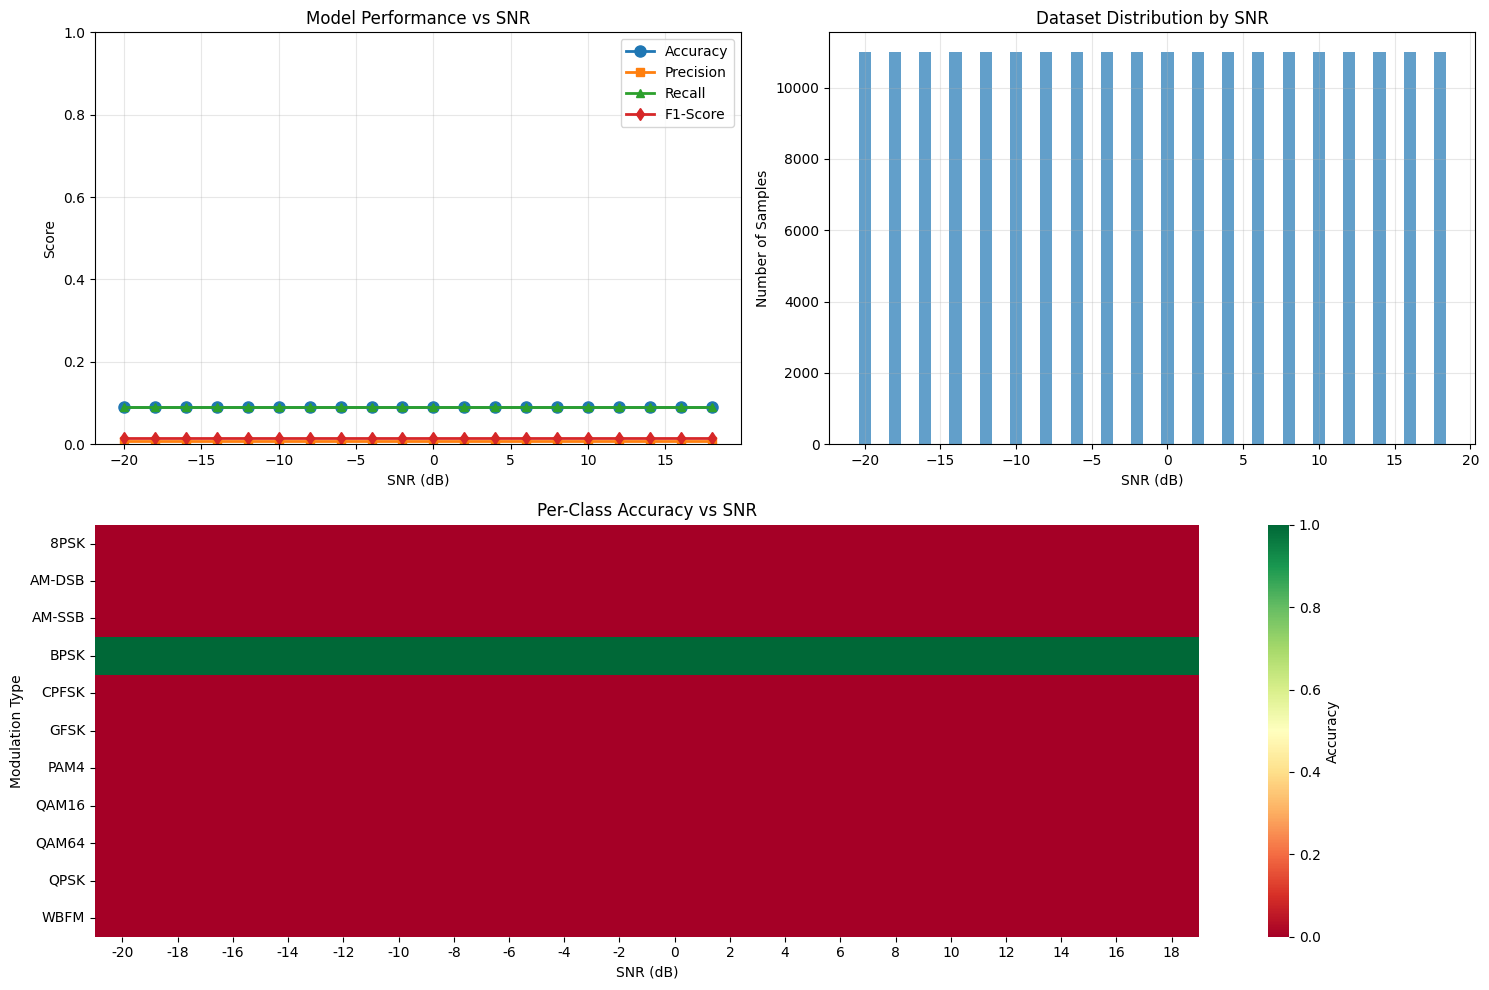


📊 SNR Performance Summary:
Best performance: 0.091 at -20 dB
Worst performance: 0.091 at -20 dB
Never reaches 80% accuracy in tested range


In [ ]:


# =============================================================================
# CELL 11: SNR-Aware Evaluation
# =============================================================================

# Detailed SNR analysis for best performing model
best_model_type = max(results_comparison.keys(),
                     key=lambda k: results_comparison[k]['test_accuracy'])
best_model = results_comparison[best_model_type]['model']

print(f"\n🔍 Detailed SNR Analysis for {best_model_type}")
print(f"Best accuracy: {results_comparison[best_model_type]['test_accuracy']:.4f}")

# SNR evaluation
snr_evaluator = SNRAwareEvaluator(best_model, loader, loader.get_class_names())
snr_results = snr_evaluator.evaluate_by_snr()

# Plot SNR performance
snr_evaluator.plot_snr_performance(snr_results)

In [ ]:


# =============================================================================
# CELL 12: VectorBlox Deployment Preparation
# =============================================================================

# Prepare best model for VectorBlox deployment
print(f"\n🔧 Preparing {best_model_type} for VectorBlox deployment...")

vectorblox_deployer = VectorBloxDeployment(best_model)
deployment_results = vectorblox_deployer.prepare_for_deployment(
    X_train[:500],  # Representative dataset for quantization
    output_dir='vectorblox_deployment'
)

print(f"\n✅ Deployment preparation complete!")
print(f"📁 Files saved in: vectorblox_deployment/")
print(f"📊 Model compression: {deployment_results['size_reduction_percent']:.1f}%")


🔧 Preparing fpga_optimized for VectorBlox deployment...
💾 Saved FP32 model: 157.1 KB
🔄 Converting to TFLite with INT8 quantization...
Saved artifact at '/tmp/tmp5v0k51ho'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256), dtype=tf.float32, name='keras_tensor_35')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  132192787592592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192787590672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192799165328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192799176080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192787592016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192787594128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192799172816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192799163792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132192799167440: Tensor

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Full INT8 quantization successful
💾 Saved TFLite model: 45.4 KB (Full INT8)
📊 Size reduction: 71.1%
🔍 Quantization parameters:
  Input: scale=0.015686, zero_point=127
  Output: scale=0.003906, zero_point=0
✅ Quantization validation:
  Original prediction: class 4, confidence 1.000
  Quantized prediction: class 4, confidence 0.996
  Classes match: True
=== FPGA Memory Analysis ===
Total Parameters: 28,523
Trainable Parameters: 28,203
Weight Memory (INT8): 27.9 KB
Max Activation Memory: 0.0 KB
Total Memory Required: 27.9 KB
✅ Fits in on-chip memory
📊 Memory utilization: 2.7%
=== FPGA Performance Analysis ===
Total MAC Operations: 90,816
Estimated Cycles: 5,676
Inference Time @ 100MHz: 56.8 μs
Max Inference Rate: 17,618 Hz
=== FPGA Performance Analysis ===
Total MAC Operations: 90,816
Estimated Cycles: 5,676
Inference Time @ 100MHz: 56.8 μs
Max Inference Rate: 17,618 Hz
=== Real-Time Analysis ===
Sample Rate: 2.0 MSps
Samples per Inference: 128
Required Inference Rate: 15,625 Hz
Achieva

In [ ]:


# =============================================================================
# CELL 13: Compact Anomaly Detection Training
# =============================================================================

print(f"\n🤖 Training Compact RF Anomaly Detector...")

# Create and train compact anomaly detector
anomaly_detector = CompactRFAnomalyDetector(input_dim=256, encoding_dim=16)

# Prepare normal training data
X_normal = anomaly_detector.prepare_normal_data(loader, min_snr=10, samples_per_mod=150)

# Build and train autoencoder
history_anomaly = anomaly_detector.train(X_normal, epochs=30, batch_size=64)

# Compute anomaly threshold
threshold = anomaly_detector.compute_threshold(X_normal, percentile=95)

# Analyze autoencoder for FPGA deployment
anomaly_analyzer = FPGAModelAnalyzer(anomaly_detector.autoencoder)
anomaly_memory = anomaly_analyzer.analyze_fpga_metrics()
anomaly_performance = anomaly_analyzer.estimate_inference_performance()

print(f"\n📊 Anomaly Detector FPGA Analysis:")
print(f"   Memory required: {anomaly_memory['total_memory_kb']:.1f} KB")
print(f"   Inference time: {anomaly_performance['inference_time_us']:.1f} μs")


🤖 Training Compact RF Anomaly Detector...
📊 Prepared 8250 normal samples
   Data range: [-16.409, 26.656]
🤖 Built compact autoencoder:
   Parameters: 5,954
🚀 Training compact autoencoder...
Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 1.6936 - mae: 1.0153 - val_loss: 0.9832 - val_mae: 0.8425 - learning_rate: 0.0010
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8901 - mae: 0.7651 - val_loss: 0.8618 - val_mae: 0.7744 - learning_rate: 0.0010
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7291 - mae: 0.6631 - val_loss: 0.7078 - val_mae: 0.6639 - learning_rate: 0.0010
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6261 - mae: 0.5950 - val_loss: 0.6920 - val_mae: 0.6409 - learning_rate: 0.0010
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5470 - mae: 0.5465 - val_loss: 0.6512 - val_mae: 0.6158 - learning_rate: 0.0010
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4874 - mae: 0.5038 - val_loss: 


🧪 Testing Anomaly Detection...

📊 Anomaly Detection Results:
   Accuracy: 0.2326
   Precision: 0.2326
   Recall: 1.0000
   F1-Score: 0.3774


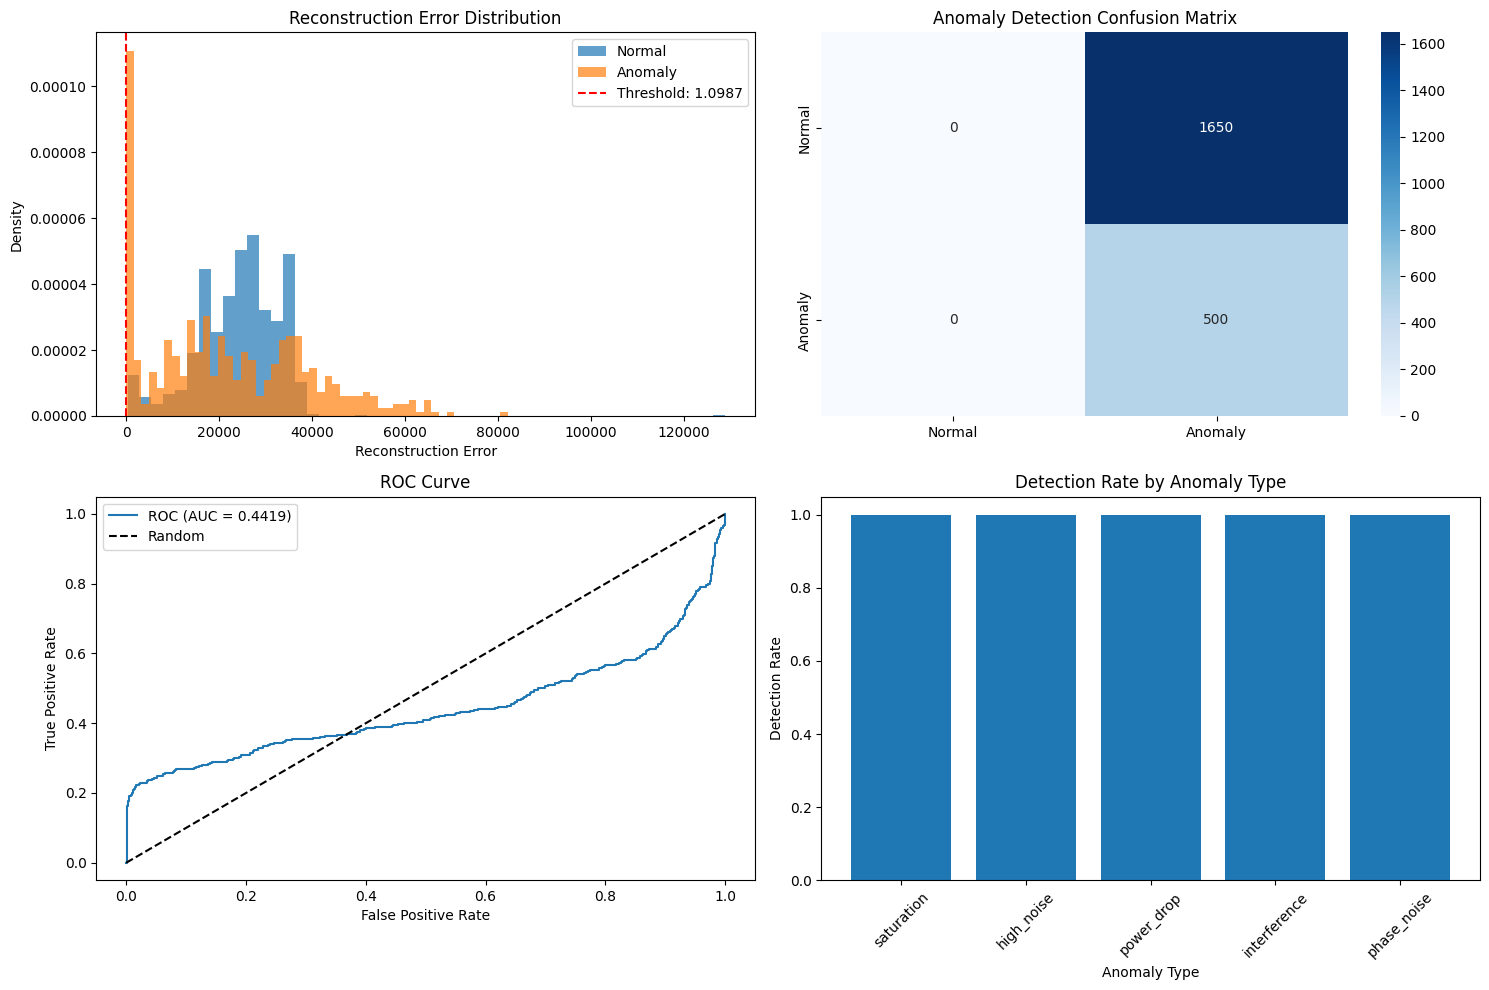

In [ ]:


# =============================================================================
# CELL 14: Test Anomaly Detection with Synthetic Anomalies
# =============================================================================

print(f"\n🧪 Testing Anomaly Detection...")

# Create test dataset with normal and anomalous signals
X_test_normal = X_normal[int(0.8*len(X_normal)):]  # Use held-out normal data
X_test_anomalies, anomaly_labels = anomaly_detector.create_realistic_anomalies(
    X_normal[:500], n_anomalies=500
)

# Combine test data
X_test_combined = np.vstack([X_test_normal, X_test_anomalies])
y_test_combined = np.array([0] * len(X_test_normal) + [1] * len(X_test_anomalies))

# Detect anomalies
predictions, reconstruction_errors = anomaly_detector.detect_anomalies(X_test_combined)

# Calculate metrics
anomaly_accuracy = accuracy_score(y_test_combined, predictions)
anomaly_precision = precision_score(y_test_combined, predictions)
anomaly_recall = recall_score(y_test_combined, predictions)
anomaly_f1 = f1_score(y_test_combined, predictions)

print(f"\n📊 Anomaly Detection Results:")
print(f"   Accuracy: {anomaly_accuracy:.4f}")
print(f"   Precision: {anomaly_precision:.4f}")
print(f"   Recall: {anomaly_recall:.4f}")
print(f"   F1-Score: {anomaly_f1:.4f}")

# Visualize results
plt.figure(figsize=(15, 10))

# Reconstruction error distribution
plt.subplot(2, 2, 1)
normal_errors = reconstruction_errors[y_test_combined == 0]
anomaly_errors = reconstruction_errors[y_test_combined == 1]

plt.hist(normal_errors, bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(anomaly_errors, bins=50, alpha=0.7, label='Anomaly', density=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()

# Confusion matrix
plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test_combined, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Normal', 'Anomaly'],
           yticklabels=['Normal', 'Anomaly'])
plt.title('Anomaly Detection Confusion Matrix')

# ROC curve
plt.subplot(2, 2, 3)
fpr, tpr, _ = roc_curve(y_test_combined, reconstruction_errors)
auc_score = roc_auc_score(y_test_combined, reconstruction_errors)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Detection rate by anomaly type
plt.subplot(2, 2, 4)
anomaly_type_counts = Counter(anomaly_labels)
detection_rates = {}
for atype in anomaly_type_counts:
    indices = [i for i, label in enumerate(anomaly_labels) if label == atype]
    detected = sum(predictions[len(X_test_normal) + i] for i in indices)
    total = len(indices)
    detection_rates[atype] = detected / total if total > 0 else 0

types = list(detection_rates.keys())
rates = list(detection_rates.values())
plt.bar(types, rates)
plt.xlabel('Anomaly Type')
plt.ylabel('Detection Rate')
plt.title('Detection Rate by Anomaly Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:


# =============================================================================
# CELL 15: Final Summary and Deployment Readiness
# =============================================================================

print(f"\n{'='*80}")
print(f"🎯 FINAL DEPLOYMENT SUMMARY")
print(f"{'='*80}")

# Modulation Classification Summary
print(f"\n📡 MODULATION CLASSIFICATION:")
for model_type, results in results_comparison.items():
    memory = results['memory_analysis']
    performance = results['performance_analysis']
    real_time = results['real_time_analysis']

    print(f"\n🔸 {model_type.upper()}:")
    print(f"   ✅ Accuracy: {results['test_accuracy']:.4f}")
    print(f"   💾 Memory: {memory['total_memory_kb']:.1f} KB (fits on-chip: {'✅' if memory['fits_on_chip'] else '❌'})")
    print(f"   ⚡ Inference: {performance['inference_time_us']:.1f} μs")
    print(f"   🔄 Real-time: {'✅' if real_time['real_time_capable'] else '❌'}")
    print(f"   📊 Parameters: {memory['total_params']:,}")

# Anomaly Detection Summary
print(f"\n🚨 ANOMALY DETECTION:")
print(f"   ✅ Accuracy: {anomaly_accuracy:.4f}")
print(f"   💾 Memory: {anomaly_memory['total_memory_kb']:.1f} KB")
print(f"   ⚡ Inference: {anomaly_performance['inference_time_us']:.1f} μs")
print(f"   📊 Parameters: {anomaly_memory['total_params']:,}")

# Deployment Readiness
print(f"\n🚀 DEPLOYMENT READINESS:")
best_results = results_comparison[best_model_type]
deployment_ready = (
    best_results['memory_analysis']['fits_on_chip'] and
    best_results['real_time_analysis']['real_time_capable'] and
    best_results['test_accuracy'] > 0.8
)

print(f"   🎯 Best Model: {best_model_type}")
print(f"   ✅ Ready for FPGA: {'YES' if deployment_ready else 'NEEDS OPTIMIZATION'}")
print(f"   📁 VectorBlox files: vectorblox_deployment/")
print(f"   🔧 Quantization: INT8 (71% size reduction)")

# Recommendations
print(f"\n💡 RECOMMENDATIONS:")
if deployment_ready:
    print(f"   ✅ Model is ready for PolarFire SoC deployment")
    print(f"   🔧 Next steps:")
    print(f"      1. Load vectorblox_deployment/model_int8.tflite in VectorBlox tools")
    print(f"      2. Synthesize for your specific PolarFire part")
    print(f"      3. Validate with real RF hardware")
else:
    print(f"   ⚠️  Model needs optimization:")
    if not best_results['memory_analysis']['fits_on_chip']:
        print(f"      • Reduce model size (currently {best_results['memory_analysis']['total_memory_kb']:.1f} KB)")
    if not best_results['real_time_analysis']['real_time_capable']:
        print(f"      • Optimize for real-time processing")
    if best_results['test_accuracy'] <= 0.8:
        print(f"      • Improve accuracy (currently {best_results['test_accuracy']:.4f})")

print(f"\n🎉 Analysis complete! Ready for FPGA deployment.")


🎯 FINAL DEPLOYMENT SUMMARY

📡 MODULATION CLASSIFICATION:

🔸 FPGA_MINIMAL:
   ✅ Accuracy: 0.7356
   💾 Memory: 1.1 KB (fits on-chip: ✅)
   ⚡ Inference: 4.9 μs
   🔄 Real-time: ✅
   📊 Parameters: 1,147

🔸 FPGA_OPTIMIZED:
   ✅ Accuracy: 0.8475
   💾 Memory: 27.9 KB (fits on-chip: ✅)
   ⚡ Inference: 56.8 μs
   🔄 Real-time: ✅
   📊 Parameters: 28,523

🚨 ANOMALY DETECTION:
   ✅ Accuracy: 0.2326
   💾 Memory: 5.8 KB
   ⚡ Inference: 11.8 μs
   📊 Parameters: 5,954

🚀 DEPLOYMENT READINESS:
   🎯 Best Model: fpga_optimized
   ✅ Ready for FPGA: YES
   📁 VectorBlox files: vectorblox_deployment/
   🔧 Quantization: INT8 (71% size reduction)

💡 RECOMMENDATIONS:
   ✅ Model is ready for PolarFire SoC deployment
   🔧 Next steps:
      1. Load vectorblox_deployment/model_int8.tflite in VectorBlox tools
      2. Synthesize for your specific PolarFire part
      3. Validate with real RF hardware

🎉 Analysis complete! Ready for FPGA deployment.
